In [1]:
import cv2
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

2023-06-20 22:07:17.893948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 22:07:18.510630: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(6,8), rows=1, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        img = cv2.imread(imspaths[i])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.imshow(img)
    f.tight_layout()

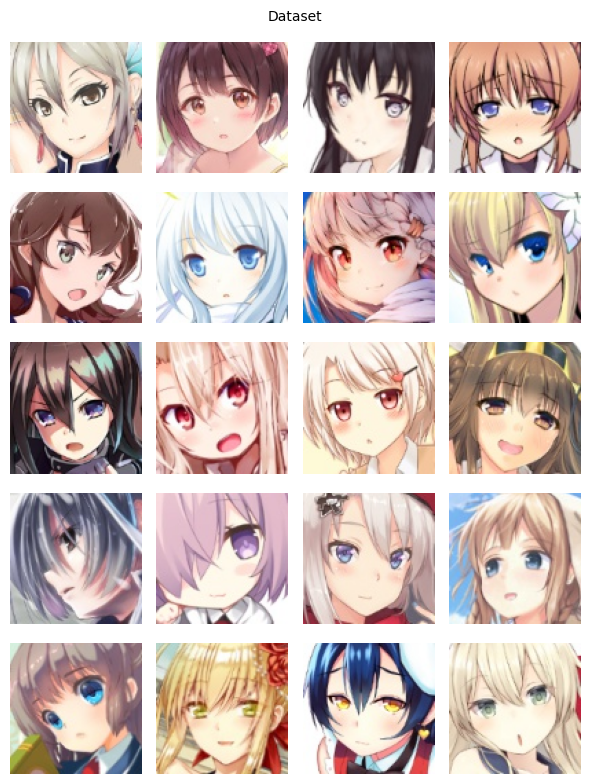

In [3]:
plots_from_files(imspaths = list(paths.list_images('./faces'))[0:20], rows = 5, maintitle = 'Dataset')

In [4]:
images = paths.list_images('./faces')

dataset = []
for imgpath in images:
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (48, 48))
    dataset.append(img/255.0)

In [5]:
np.array(dataset).shape

(71314, 48, 48, 3)

In [6]:
BS = 32

dataset = tf.data.Dataset.from_tensor_slices(np.array(dataset))
dataset = dataset.shuffle(buffer_size=1024).batch(BS)

2023-06-20 22:07:41.102478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38370 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-06-20 22:07:41.105243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 29049 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-06-20 22:07:41.107719: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 29117 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-06-20 22:07:41.110388: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38370 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [7]:
tf.keras.backend.clear_session()

In [8]:
Noise_Dim = 150

generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(Noise_Dim,)),
    layers.Dense(6*6*256),
    layers.BatchNormalization(),
    layers.Reshape(target_shape=(6, 6, 256)),
    layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(3, 3, activation='relu', strides=2, padding='same')
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9216)              1391616   
                                                                 
 batch_normalization (BatchN  (None, 9216)             36864     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 6, 6, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 256)      590080    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 256)      1024      
 hNormalization)                                                 
                                                        

In [9]:
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(48, 48, 3)),
    layers.Conv2D(64, 3, activation='LeakyReLU', strides=2, padding='same'),
    layers.Conv2D(128, 3, activation='LeakyReLU', strides=2, padding='same'),
    layers.Conv2D(256, 3, activation='LeakyReLU', strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='LeakyReLU'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                589888    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [10]:
optG = keras.optimizers.Adam(learning_rate=0.0001)
optD = keras.optimizers.Adam(learning_rate=0.00001)

lossG = keras.losses.BinaryCrossentropy(from_logits=True)
lossD = keras.losses.BinaryCrossentropy()

In [11]:
## train disciminator to classify original img and gerenated img
@tf.function
def trainDStep(data):
    BS = tf.shape(data)[0]
    
    Noise = tf.random.normal(shape=(BS, Noise_Dim))
    
    y_true = tf.concat(
        [
            tf.ones(BS, 1),    # label 1 : real image
            tf.zeros(BS, 1),   # label 0 : generated image
        ], 
        axis=0
    )
    
    with tf.GradientTape() as tape:
        fake = generator(Noise)
        x  = tf.concat([tf.cast(data, tf.float32), fake], axis=0)
        y_pred = discriminator(x)
        discriminatorLoss = lossD(y_true, y_pred)
        
    grad = tape.gradient(discriminatorLoss, discriminator.trainable_variables)
    optD.apply_gradients(zip(grad, discriminator.trainable_variables))
    
    return{
        'discriminator_loss' : discriminatorLoss
    }

In [12]:
## train generator make fake img
@tf.function
def trainGStep(data):
    BS = tf.shape(data)[0]
    
    Noise = tf.random.normal(shape=(BS, Noise_Dim))
    
    y_true = tf.ones(BS, 1)
    
    with tf.GradientTape() as tape:
        y_pred = discriminator(generator(Noise))  # make generated img looks like real image
        generatorLoss = lossG(y_true, y_pred)
    grad = tape.gradient(generatorLoss, generator.trainable_variables)
    optG.apply_gradients(zip(grad, generator.trainable_variables))
    
    return{
        'generator_loss' : generatorLoss
    }

In [13]:
def plot_result(model):
    images = model(np.random.normal(size=(5*5, Noise_Dim)))
    
    plt.figure(figsize=(5,5))
    for i, image in enumerate(images):
        image = image.numpy()
        
        # min-max normalization
        min_vals = np.min(image, axis=(0,1,2))
        max_vals = np.max(image, axis=(0,1,2))
        image = (image - min_vals) / (max_vals - min_vals)
        
        plt.subplot(5, 5, i+1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

2023-06-20 22:07:45.896243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [71314,48,48,3]
	 [[{{node Placeholder/_0}}]]
2023-06-20 22:07:45.896529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [71314,48,48,3]
	 [[{{node Placeholder/_0}}]]
2023-06-20 22:07:47.495606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-20 22:07:47.653015: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN versio

epoch:0        DiscriminatorLoss:0.70        GeneratorLoss:0.48


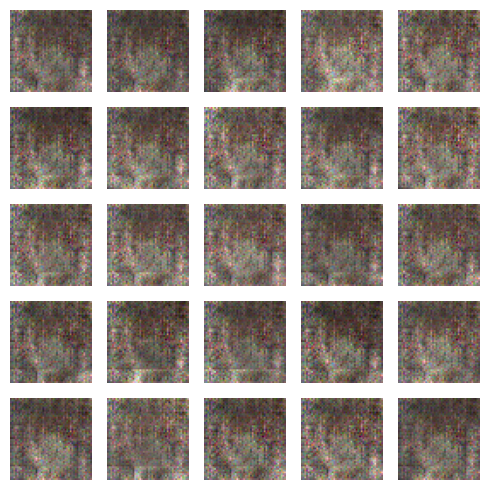

epoch:1        DiscriminatorLoss:0.70        GeneratorLoss:0.47
epoch:2        DiscriminatorLoss:0.70        GeneratorLoss:0.47
epoch:3        DiscriminatorLoss:0.70        GeneratorLoss:0.47
epoch:4        DiscriminatorLoss:0.70        GeneratorLoss:0.47
epoch:5        DiscriminatorLoss:0.70        GeneratorLoss:0.47


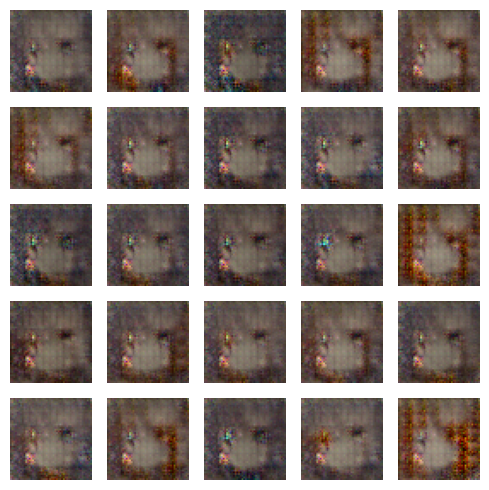

epoch:6        DiscriminatorLoss:0.70        GeneratorLoss:0.47
epoch:7        DiscriminatorLoss:0.70        GeneratorLoss:0.48
epoch:8        DiscriminatorLoss:0.69        GeneratorLoss:0.48
epoch:9        DiscriminatorLoss:0.70        GeneratorLoss:0.47
epoch:10        DiscriminatorLoss:0.69        GeneratorLoss:0.47


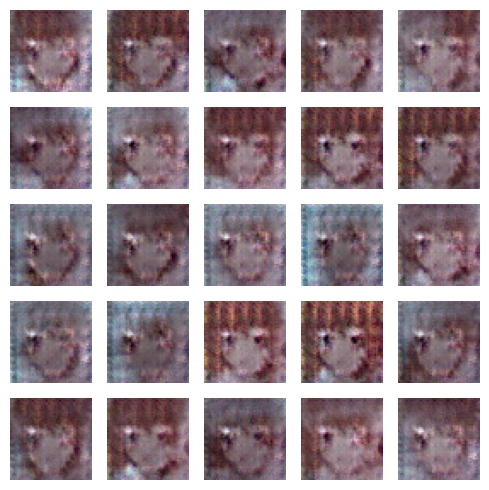

epoch:11        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:12        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:13        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:14        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:15        DiscriminatorLoss:0.70        GeneratorLoss:0.47


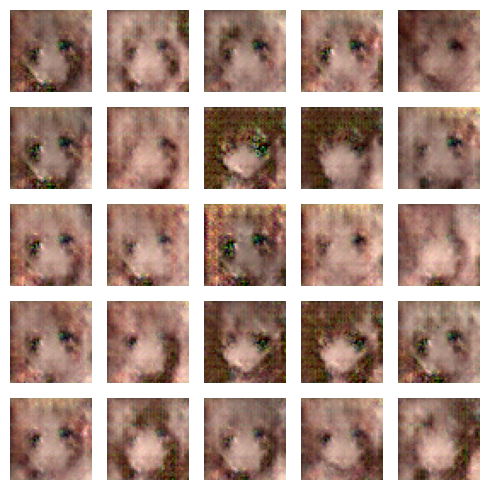

epoch:16        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:17        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:18        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:19        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:20        DiscriminatorLoss:0.69        GeneratorLoss:0.47


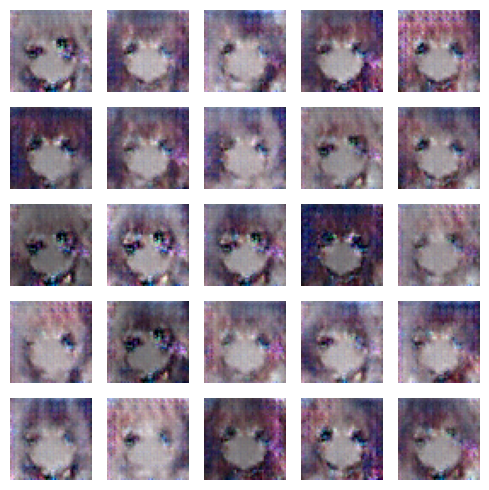

epoch:21        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:22        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:23        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:24        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:25        DiscriminatorLoss:0.69        GeneratorLoss:0.47


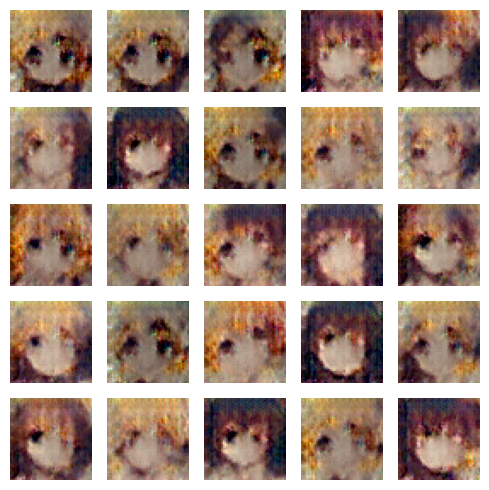

epoch:26        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:27        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:28        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:29        DiscriminatorLoss:0.69        GeneratorLoss:0.48
epoch:30        DiscriminatorLoss:0.69        GeneratorLoss:0.47


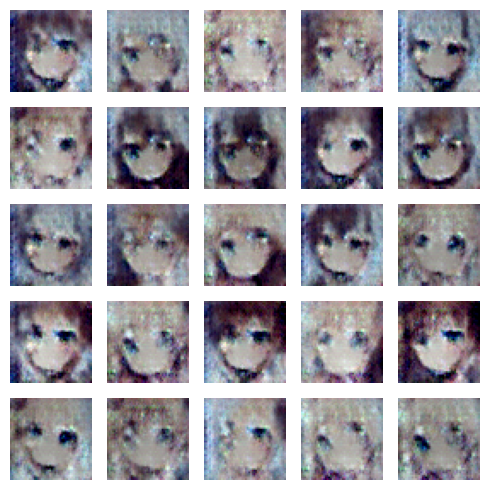

epoch:31        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:32        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:33        DiscriminatorLoss:0.69        GeneratorLoss:0.48
epoch:34        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:35        DiscriminatorLoss:0.69        GeneratorLoss:0.47


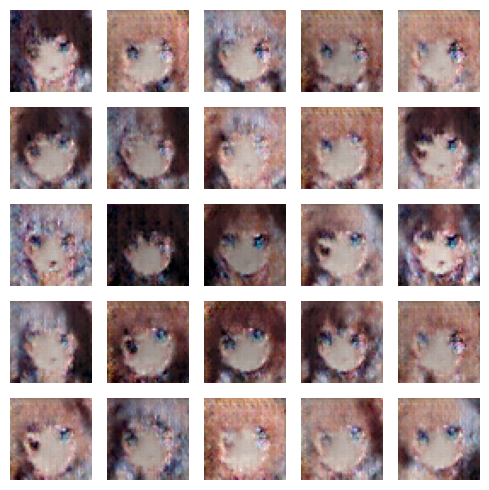

epoch:36        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:37        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:38        DiscriminatorLoss:0.69        GeneratorLoss:0.47
epoch:39        DiscriminatorLoss:0.69        GeneratorLoss:0.47


In [14]:
for epoch in range(40):
    dLossSum = 0
    gLossSum = 0
    cnt = 0
    
    for batch in dataset:
        dLoss = trainDStep(batch)
        dLossSum += dLoss['discriminator_loss']
        
        gLoss = trainGStep(batch)
        gLossSum += gLoss['generator_loss']
        
        cnt += 1
        
    print(f'epoch:{epoch}        DiscriminatorLoss:{dLossSum/cnt :.2f}        GeneratorLoss:{gLossSum/cnt :.2f}')
    
    if epoch % 5 == 0:
        plot_result(generator)

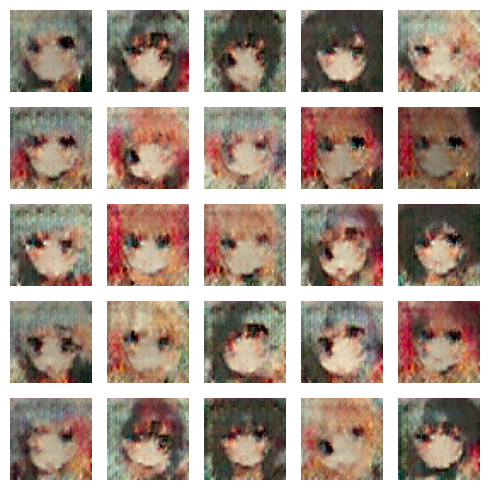

In [15]:
plot_result(generator)